Initializing NUTS using jitter+adapt_diag...
C:\Users\office\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\tensor\rewriting\elemwise.py:1024: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, C, sigma]


C:\Users\office\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages
\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
Sampling: [Y_obs]


C:\Users\office\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages
\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing NUTS using jitter+adapt_diag...
C:\Users\office\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\tensor\rewriting\elemwise.py:1024: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R1, R2, C1, C2, sigma]


C:\Users\office\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages
\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 939 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Y_obs]


C:\Users\office\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages
\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Observed Mean (Circuit A): 180.26953335641082
Simulated Mean (Circuit A): 166.36530517397568
Observed Mean (Circuit B): 178.0340520793838
Simulated Mean (Circuit B): 177.26273446484439


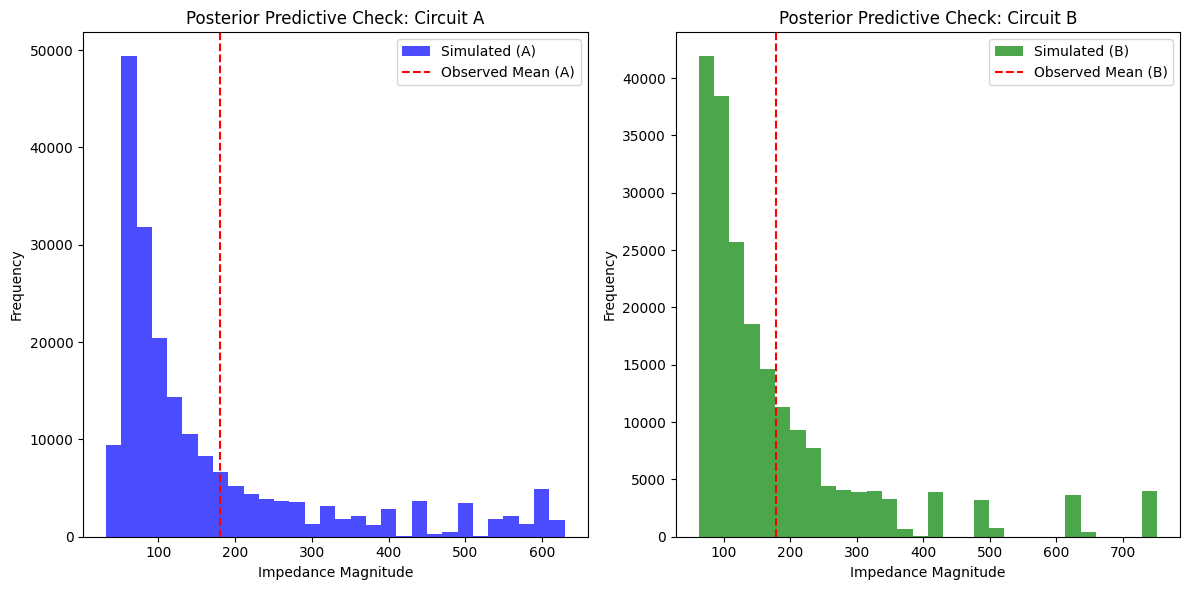

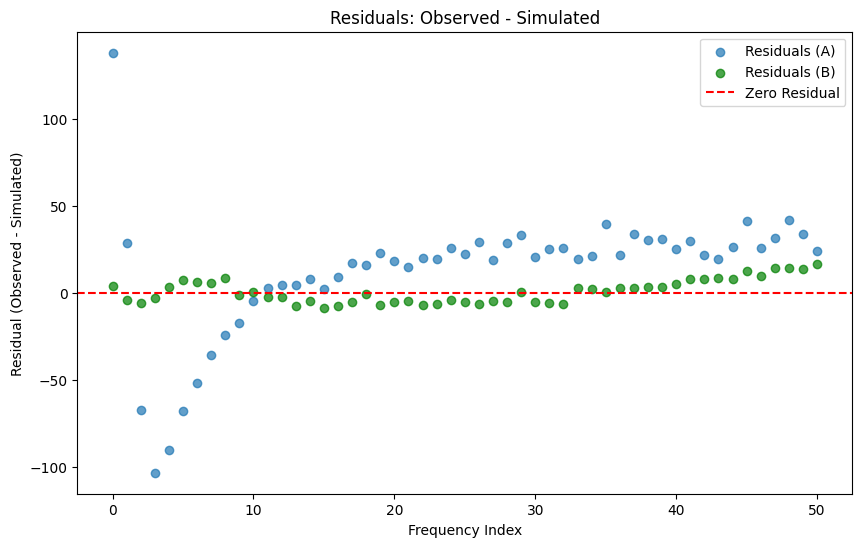

Circuit B is a better match for the observed data.


In [ ]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

def bayesian_analysis():
    """
    This function Performs Bayesian analysis for Circuit A and Circuit B, analyze posterior predictive checks,
    and determine which circuit better matches the observed data using histograms.
    """
    # Step 1: Loading the Data spectral data for Circuit A and Circuit B from provided file paths
    # Each dataset contains impedance values recorded across a frequency range
    data_a = np.load('C:/Users/office/Downloads/Circuit1/spectrum-f_min_0-f_max_12501-f_step_250.npz')
    data_b = np.load('C:/Users/office/Downloads/Circuit2/spectrum-f_min_0-f_max_12501-f_step_250.npz')

    # Extracting the complex impedance data from the loaded files
    # The first column of each dataset corresponds to the impedance at each frequency
    impedance_a = data_a['arr_0']
    impedance_b = data_b['arr_0']

    # Calculating the magnitude (absolute value) of impedance for Circuit A and Circuit B
    magnitude_a = np.abs(impedance_a[:, 0])
    magnitude_b = np.abs(impedance_b[:, 0])

    # Defining the frequency range for the spectral data
    # Frequencies are evenly spaced between 0 and 12500 Hz, corresponding to the measurements
    frequencies = np.linspace(0, 12500, len(magnitude_a))
    
    frequencies[frequencies == 0] = 1e-6 # Tis avoids division by zero in calculations by replacing 0 Hz with a very small value

   
    # Step 2: Bayesian Inference for Circuit A
    # Use a probabilistic model to infer the parameters of Circuit A (R, C)
  
    with pm.Model() as model_a:
         # Define priors for the resistance (R) and capacitance (C)
        # These represent our prior beliefs about the likely values for these parameters
        R = pm.Uniform('R', lower=100, upper=10000)  # Resistance in ohms
        C = pm.Uniform('C', lower=1e-8, upper=1e-5)  # Capacitance in farads
        sigma = pm.HalfNormal('sigma', sigma=0.1)  # Standard deviation of noise in observations


        # Defining the theoretical impedance model for Circuit A
        # Z = R / sqrt(1 + (2 * pi * freq * R * C)^2)
        Z_theoretical = R / pm.math.sqrt(1 + (2 * np.pi * frequencies * R * C) ** 2)
         # Define the likelihood function: how likely the observed data is given the model
        Y_obs = pm.Normal('Y_obs', mu=Z_theoretical, sigma=sigma, observed=magnitude_a)

        # Perform MCMC sampling to estimate the posterior distributions of the parameters
        trace_a = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Perform posterior predictive checks for Circuit A
    # This step simulates new data based on the posterior distributions to compare with the observed data
    ppc_a = pm.sample_posterior_predictive(trace_a, model=model_a)
    simulated_a = ppc_a.posterior_predictive["Y_obs"].values.flatten()

    # Step 3: Bayesian Inference for Circuit B
    with pm.Model() as model_b:
        R1 = pm.Uniform('R1', lower=100, upper=10000)
        R2 = pm.Uniform('R2', lower=100, upper=10000)
        C1 = pm.Uniform('C1', lower=1e-8, upper=1e-5)
        C2 = pm.Uniform('C2', lower=1e-8, upper=1e-5)
        sigma = pm.HalfNormal('sigma', sigma=0.1)

        Z1 = R1 / pm.math.sqrt(1 + (2 * np.pi * frequencies * R1 * C1) ** 2)
        Z2 = R2 / pm.math.sqrt(1 + (2 * np.pi * frequencies * R2 * C2) ** 2)
        Z_theoretical = Z1 + Z2

        Y_obs = pm.Normal('Y_obs', mu=Z_theoretical, sigma=sigma, observed=magnitude_b)

        trace_b = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Posterior Predictive Check
    ppc_b = pm.sample_posterior_predictive(trace_b, model=model_b)
    simulated_b = ppc_b.posterior_predictive["Y_obs"].values.flatten()

    # Step 4: Visualization and Histogram Analysis
    observed_mean_a = np.mean(magnitude_a)
    observed_mean_b = np.mean(magnitude_b)

    simulated_mean_a = np.mean(simulated_a)
    simulated_mean_b = np.mean(simulated_b)

    print(f"Observed Mean (Circuit A): {observed_mean_a}")
    print(f"Simulated Mean (Circuit A): {simulated_mean_a}")
    print(f"Observed Mean (Circuit B): {observed_mean_b}")
    print(f"Simulated Mean (Circuit B): {simulated_mean_b}")

    # Histogram Visualization
    plt.figure(figsize=(12, 6))

    # Histogram for Circuit A
    plt.subplot(1, 2, 1)
    plt.hist(simulated_a, bins=30, alpha=0.7, label="Simulated (A)", color="blue")
    plt.axvline(observed_mean_a, color='red', linestyle='--', label="Observed Mean (A)")
    plt.title("Posterior Predictive Check: Circuit A")
    plt.xlabel("Impedance Magnitude")
    plt.ylabel("Frequency")
    plt.legend()

    # Histogram for Circuit B
    plt.subplot(1, 2, 2)
    plt.hist(simulated_b, bins=30, alpha=0.7, label="Simulated (B)", color="green")
    plt.axvline(observed_mean_b, color='red', linestyle='--', label="Observed Mean (B)")
    plt.title("Posterior Predictive Check: Circuit B")
    plt.xlabel("Impedance Magnitude")
    plt.ylabel("Frequency")
    plt.legend()

    plt.tight_layout()
    plt.show()


    residual_a = magnitude_a - simulated_a[:len(magnitude_a)]
    residual_b = magnitude_b - simulated_b[:len(magnitude_b)]

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(residual_a)), residual_a, alpha=0.7, label="Residuals (A)")
    plt.scatter(range(len(residual_b)), residual_b, alpha=0.7, label="Residuals (B)", color='green')
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual")
    plt.title("Residuals: Observed - Simulated")
    plt.xlabel("Frequency Index")
    plt.ylabel("Residual (Observed - Simulated)")
    plt.legend()
    plt.show()



    # Step 5: Decision Making
    diff_a = abs(observed_mean_a - simulated_mean_a)
    diff_b = abs(observed_mean_b - simulated_mean_b)

    if diff_a < diff_b:
        print("Circuit A is a better match for the observed data.")
    else:
        print("Circuit B is a better match for the observed data.")

if __name__ == '__main__':
    bayesian_analysis()
 